In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils import algorithm_globals
from metrics import get_aproximation_ratio

In [47]:
def get_portfolio_data(tickers, start_date, end_date):
    """
    Fetches historical data and calculates expected return (mu) and covariance (sigma).
    """
    #Fetch raw data from Yahoo Finance

    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    #Calculate daily returns (percentage change)
    daily_returns = data.pct_change().dropna()
    
    #Calculate Mean Vector (mu) and Covariance Matrix (sigma)
    '''252 because if not, mu is the average daily returns and overall we want annual returns because it makes more sense.
    So just multiply the average daily returns by the 252 annual trading days'''
    mu = daily_returns.mean() * 252
    sigma = daily_returns.cov() * 252
    
    return mu, sigma, data

def normalize_data(mu, sigma):
    """
    Normalizes data to [0, 1] range.
    """
    mu_min = mu.min()
    mu_max = mu.max()
    mu_normalized = (mu - mu_min) / (mu_max - mu_min) #Normalization between [0,1]

    sigma_max = sigma.max().max()
    sigma_normalized = sigma / sigma_max #Normalization of sigma (the covariance matrix)
    
    return mu_normalized, sigma_normalized

def create_portfolio_qp(mu, sigma, q=0.5, budget=None):
    """
    Creates a Quadratic Program for the Portfolio Optimization problem.
    
    Args:
        mu (numpy.ndarray): Expected returns vector.
        sigma (numpy.ndarray): Covariance matrix.
        q (float): Risk factor (0 = high risk/high return, 1 = low risk).
        budget (int): Number of assets to select. If None, defaults to half the assets.
        
    Returns:
        qp (QuadraticProgram): The mathematical formulation of the problem.
        penalty (float): The recommended penalty scaling factor for QUBO conversion.
    """
    num_assets = len(mu)
    
    if budget is None:
        budget = num_assets // 2
        
    # Set parameter to scale the budget penalty term
    penalty = num_assets 
    
    # Create the portfolio instance
    portfolio = PortfolioOptimization(
        expected_returns=mu.values, 
        covariances=sigma.values, 
        risk_factor=q, 
        budget=budget
    )
    
    # Convert to Qiskit's QuadraticProgram format
    qp = portfolio.to_quadratic_program()
    
    return qp, penalty,portfolio

def print_result(result,portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [ ]:
#Parameters
tickers = ["AAPL", "GOOG", "MSFT","AMZN","META"]#["MRNA", "PFE","PYPL","ENPH", "SEDG"]+["AAPL", "GOOG", "MSFT", "TSLA","AMZN","META","NVDA","NFLX"]#+["MRNA", "PFE", "ENPH", "SEDG", "WBA", "PYPL"]
start_date = "2023-01-01"
end_date = "2024-01-01"
n_stocks = len(tickers)//2
risk = 0.2

#Data Retrieval
mu_raw, sigma_raw, prices = get_portfolio_data(tickers, start_date, end_date)

#Normalization
#print("Expected Returns (mu):\n", mu_raw)
mu_norm, sigma_norm = normalize_data(mu_raw, sigma_raw)

#Portfolio QP Creation
qp_realdata, penalty,portfolio_qp = create_portfolio_qp(mu_norm,sigma_norm,q=risk,budget=n_stocks)

# Exact Solver Implementation
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp_realdata)

print_result(result,portfolio_qp)


# QAOA Implementation
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=20)
result = qaoa.solve(qp_realdata)


print_result(result,portfolio_qp)

C:\Users\andre\AppData\Local\Temp\ipykernel_11596\28816047.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


Optimal: selection [0. 1. 0. 1. 0.], value -0.7247

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0]	-0.7247		1.0000
Optimal: selection [0. 1. 0. 1. 0.], value -0.7247

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	0.1476		0.0986
[0 0 1 0 1]	0.1840		0.0859
[0 1 0 0 1]	0.0316		0.0840
[1 1 0 0 0]	0.0066		0.0811
[1 0 1 0 0]	0.1882		0.0801
[0 1 0 1 0]	-0.7247		0.0684
[0 0 1 1 0]	-0.5570		0.0625
[0 1 1 0 0]	0.0944		0.0625
[0 0 0 1 1]	-0.6376		0.0439
[0 0 0 1 0]	-0.8000		0.0400
[1 1 0 1 0]	-0.4928		0.0322
[1 0 0 1 0]	-0.6415		0.0312
[0 0 1 1 1]	-0.2941		0.0254
[1 0 0 1 1]	-0.4098		0.0225
[1 1 0 0 1]	0.2245		0.0176
[1 1 1 1 1]	0.4415		0.0166
[0 1 0 1 1]	-0.4418		0.0156
[0 1 1 1 0]	-0.3256		0.0156
[1 0 1 1 0]	-0.3159		0.0156
[1 1 1 0 0]	0.3006		0.0146
[0 1 0 0 0]	-0.1170		0.0137
[1 0 1 0 1]	0.3860		0.0

Function to generate different plots for each calssical optmizer

In [ ]:
def different_optmizers_plot(qp, penalty, plot_reps, optimizers_to_test):
    """
    Runs QAOA using various classical optimizers on a specific Quadratic Program and 
    plots the probability distribution of outcomes, highlighting the optimal solution found.

    This function iterates through a provided dictionary of Qiskit optimizers, solves 
    the given Portfolio Optimization problem (qp) using QAOA at a specified circuit 
    depth, and generates a bar chart comparing the probabilities. The bitstring 
    corresponding to the optimal solution found in each specific run is highlighted in green.

    Args:
        qp (QuadraticProgram): The Qiskit Quadratic Program object representing the 
            portfolio optimization problem.
        penalty (float): The Lagrange multiplier (penalty factor) used to enforce 
            constraints in the Hamiltonian.
        plot_reps (int): The depth of the QAOA circuit (number of layers/repetitions).
        optimizers_to_test (dict): A dictionary where keys are strings (names of the 
            optimizers) and values are configured Qiskit optimizer instances.

    Returns:
        None: Displays a matplotlib figure using `plt.show()`.

    Raises:
        NameError: If `algorithm_globals`, `QAOA`, `Sampler`, `MinimumEigenOptimizer`, 
            `np`, or `plt` are not defined in the scope.
    """
    
    results_for_plotting = {}

    print(f"Running QAOA with reps={plot_reps}...")
    print("-" * 50)

    # 2. Loop to Run QAOA and Collect Data
    for opt_name, optimizer in optimizers_to_test.items():
        # Reset seed for consistent comparison between optimizers
        algorithm_globals.random_seed = 1234
        
        # Configure QAOA with the passed optimizer and reps
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=optimizer, reps=plot_reps)
        
        # Use the 'penalty' argument passed to the function
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty) 
        
        # Solve the 'qp' argument passed to the function
        result = qaoa.solve(qp)
        
        # Capture the specific optimal solution found in THIS run
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
        
        results_for_plotting[opt_name] = {
            "probs": sorted_probs,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval
        }
        
        print(f"Finished {opt_name}. Best solution found: {found_optimal_str} (Value: {result.fval:.4f})")

    # 3. Generate Plots
    fig, axes = plt.subplots(nrows=len(optimizers_to_test), ncols=1, figsize=(12, 5 * len(optimizers_to_test)))

    if len(optimizers_to_test) == 1:
        axes = [axes]

    for i, (opt_name, data) in enumerate(results_for_plotting.items()):
        ax = axes[i]
        probs = data["probs"]
        run_optimal_str = data["optimal_str"]
        
        top_n = 15
        bitstrings_raw = list(probs.keys())[:top_n]
        values = list(probs.values())[:top_n]
        
        # Reverse bitstrings for plotting labels
        labels = [b[::-1] for b in bitstrings_raw]
        
        bars = ax.bar(labels, values, color='skyblue', edgecolor='black')
        
        # Highlight Logic
        found_in_top_n = False
        for bar, label in zip(bars, labels):
            if label == run_optimal_str:
                bar.set_facecolor('green')
                bar.set_linewidth(2)
                found_in_top_n = True
                
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        'Optimal', ha='center', va='bottom', fontsize=9, color='green', fontweight='bold')

        ax.set_title(f"Optimizer: {opt_name} | Found Optimal: {run_optimal_str}", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1.0) 
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        if not found_in_top_n:
            ax.text(0.95, 0.95, f"Optimal ({run_optimal_str}) not in top {top_n}!", 
                    transform=ax.transAxes, color='red', ha='right', fontweight='bold')

    plt.xlabel("Bitstrings (Selections)", fontsize=12)
    plt.tight_layout()
    plt.show()

Test different classical optmizers for QAOA

Running QAOA with reps=3...
--------------------------------------------------
Finished COBYLA. Best solution found: 01010 (Value: -0.7247)
Finished SPSA. Best solution found: 01010 (Value: -0.7247)
Finished POWELL. Best solution found: 01010 (Value: -0.7247)


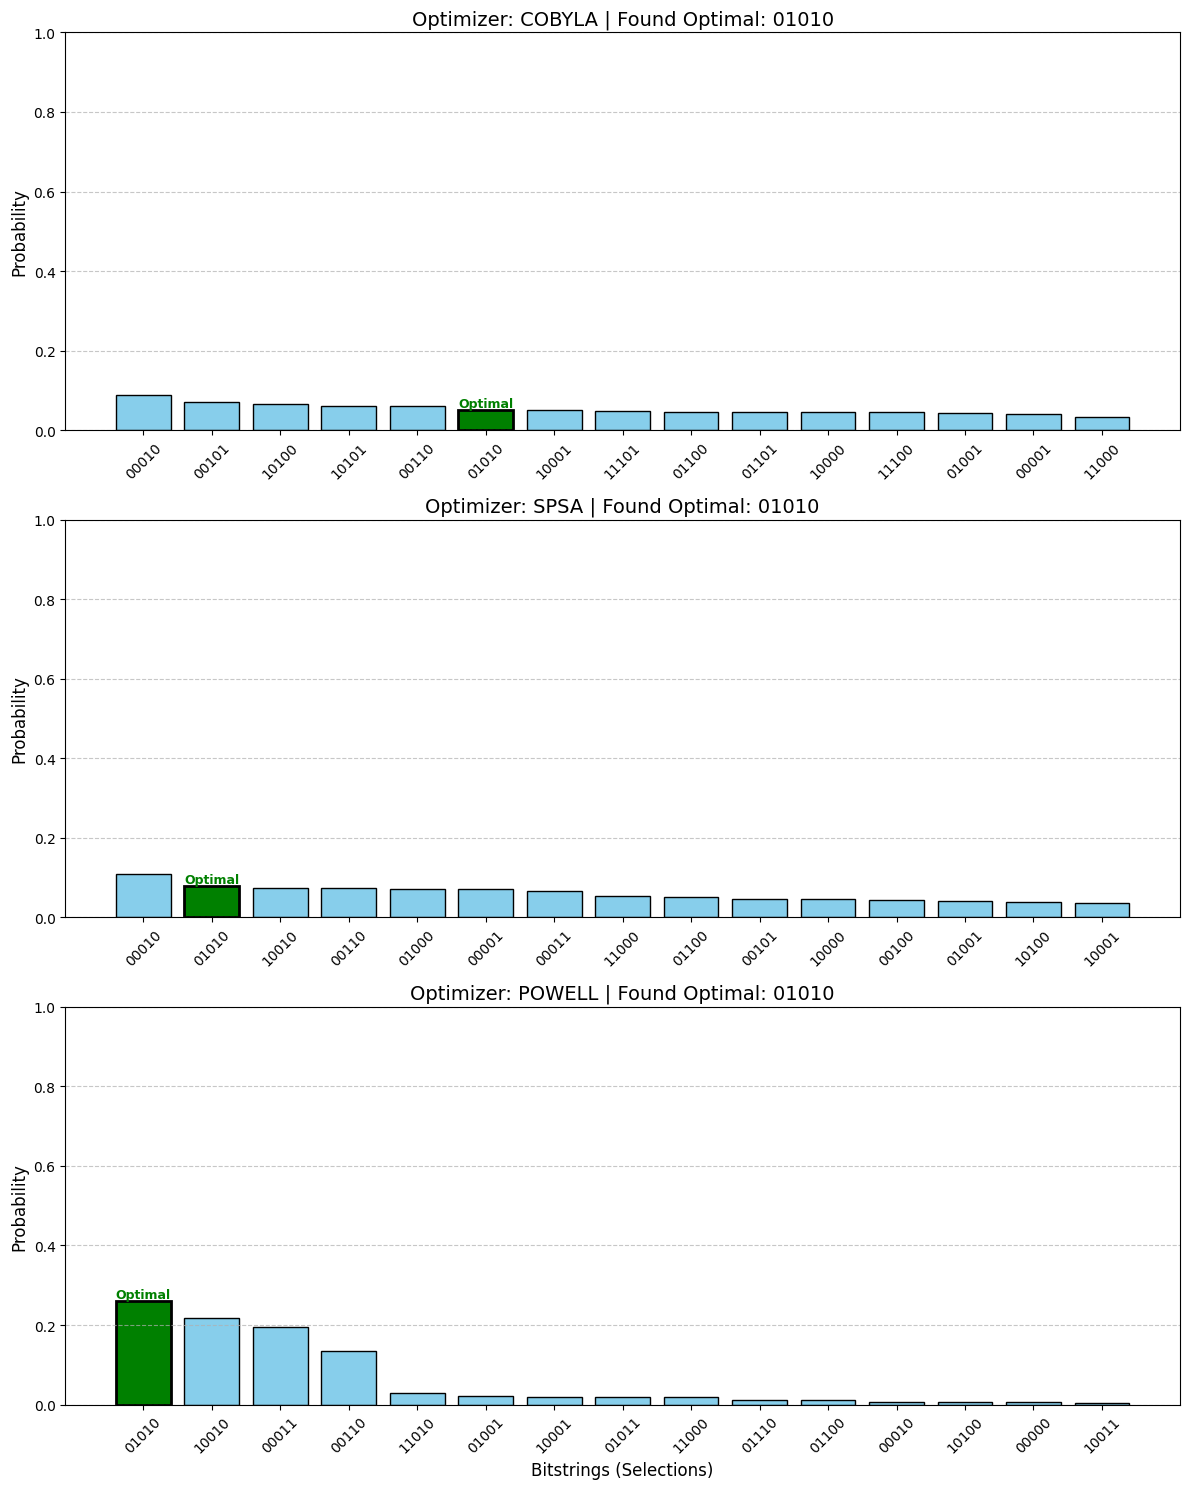

In [50]:
iter=200
p = 3
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=iter),
        "SPSA": SPSA(maxiter=iter),
        "POWELL": POWELL(maxiter=iter)
    }

different_optmizers_plot(qp=qp_realdata, penalty=penalty, plot_reps=p, optimizers_to_test=optimizers_to_test)